#Модуль 1. Диффузионные модели. Часть 1.
##Семинар №2. Работа с библиотекой HuggingFace

## **Цель занятия**
Освоить работу с основной библиотекой по диффузии diffusers(huggingface) и научиться применять ее для обучения диффузионных моделей.

Содержание

## 🤗 Обучение с diffusers

В последние месяцы стало ясно, что диффузионные модели заняли трон самых современных генеративных моделей. Здесь мы будем использовать новую библиотеку [Diffusers](https://github.com/huggingface/diffusers) Hugging Face для обучения простой модели диффузии.

## Установка зависимостей

В этом блокноте используется библиотека [🤗 Datasets](https://huggingface.co/docs/datasets/index) для загрузки и предварительной обработки наборов данных изображений.

In [ ]:
# импорт 58 сек
!pip install diffusers -U
!pip install huggingface_hub
!pip install transformers==4.25.0
!pip install datasets
!pip install accelerate #либо low_cpu_mem_usage=False
!sudo apt -qq install git-lfs
!git config --global credential.helper store
#!git lfs install
;#Add ; by the end of the cell to hide the output of that cell.

git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


Чтобы поделиться своей моделью с сообществом, необходимо выполнить еще несколько шагов.|

Сначала вам нужно сохранить свой токен аутентификации с веб-сайта Hugging Face (зарегистрируйтесь [здесь](https://huggingface.co/join), если вы еще этого не сделали!), затем выполните следующую ячейку и введите свой **write* * токен:

In [ ]:
from huggingface_hub import login
from google.colab import userdata
login(userdata.get('secretName'))

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Затем вам нужно установить Git-LFS для загрузки чекпоинтов модели:

## Понимание пайплайнов, моделей и планировщиков

Diffusers разработан как удобный и гибкий набор инструментов для создания диффузионных моделей, адаптированных к вашему сценарию использования. В основе набора инструментов лежат модели и scheduler. Хотя [DiffusionPipeline](https://huggingface.co/docs/diffusers/main/en/api/pipelines/overview#diffusers.DiffusionPipeline) для удобства объединяет эти компоненты, вы также можете разделить пайплайн и использовать модели и планировщики отдельно для создания новых диффузионных моделей.

В этом руководстве вы узнаете, как использовать модели и планировщики для сборки системы диффузии для вывода, начиная с базового пайплайна и затем переходя к пайплайну Stable Diffusion.

In [ ]:
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline,
)

text2img = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
img2img = StableDiffusionImg2ImgPipeline(**text2img.components)
inpaint = StableDiffusionInpaintPipeline(**text2img.components)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

### Деконструируем базовый пайплайн

Пайплайн — это быстрый и простой способ запустить модель для вывода, требующий не более четырех строк кода для генерации изображения:

In [ ]:
from diffusers import DDPMPipeline #если здесь ошибка, то переключить на Т4
#https://github.com/Uminosachi/sd-webui-inpaint-anything/issues/35
ddpm = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256",low_cpu_mem_usage=False).to("cuda")
image = ddpm(num_inference_steps=50).images[0]
image

In [ ]:
!ls -lha
!pwd

Это было очень просто, но как пайплайн этот сделать? Давайте разберем его и посмотрим, что происходит под капотом.

В приведенном выше примере пайплайн содержит модель UNet2DModel и DDPMScheduler. Он удаляет шум изображения, беря случайный шум размером с желаемый результат и несколько раз пропуская его через модель. На каждом временном шаге модель прогнозирует остаточный шум, и scheduler использует его для прогнозирования менее зашумленного изображения. Пайплайн повторяет этот процесс до тех пор, пока не достигнет конца указанного количества шагов вывода.

Чтобы воссоздать пайплайн с моделью и планировщиком отдельно, давайте напишем собственный процесс шумоподавления.

Загрузите модель и планировщик:

In [ ]:
from diffusers import DDPMScheduler, UNet2DModel

scheduler = DDPMScheduler.from_pretrained("google/ddpm-celebahq-256",local_files_only=True,low_cpu_mem_usage=False) #,local_files_only=True,low_cpu_mem_usage=False
model = UNet2DModel.from_pretrained("google/ddpm-celebahq-256",local_files_only=True,low_cpu_mem_usage=False).to("cuda")

2. Установите количество временных шагов для запуска процесса denoising для:

In [ ]:
scheduler.set_timesteps(50)

3. Установка временных шагов планировщика создает тензор с равномерно расположенными элементами, в этом примере 50. Каждый элемент соответствует временному шагу, на котором модель удаляет шум изображения. Когда вы позже создадите цикл шумоподавления, вы будете перебирать этот тензор, чтобы удалить шум изображения:

In [ ]:
scheduler.timesteps

4. Создайте случайный шум той же формы, что и желаемый результат:

In [ ]:
import torch

sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size)).to("cuda")

5. Теперь напишите цикл для перебора временных шагов. На каждом временном шаге модель выполняет проход [UNet2DModel.forward()](https://huggingface.co/docs/diffusers/main/en/api/models/unet2d#diffusers.UNet2DModel.forward) и возвращает зашумленный остаток . Метод планировщика [step()](https://huggingface.co/docs/diffusers/main/en/api/schedulers/ddpm#diffusers.DDPMScheduler.step) принимает шумовой остаток, временной шаг и входные данные и прогнозирует изображение на предыдущем временном шаге. Этот вывод становится следующим входом модели в цикле шумоподавления и будет повторяться до тех пор, пока не достигнет конца массива `timesteps`.

In [ ]:
input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

Это весь процесс шумоподавления, и вы можете использовать этот же шаблон для написания любой диффузионной системы.

6. Последний шаг — преобразовать вывод с шумоподавлением в изображение:

In [ ]:
from PIL import Image
import numpy as np

image = (input / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
image = Image.fromarray((image * 255).round().astype("uint8"))
image

В следующем разделе вы проверите свои навыки и разберёте более сложный pipeline Stable Diffusion. Действия более-менее одинаковые. Вы инициализируете необходимые компоненты и устанавливаете количество временных шагов для создания массива «timestep». Массив timestep используется в цикле шумоподавления, и для каждого элемента этого массива модель прогнозирует менее зашумленное изображение. Цикл шумоподавления повторяется по временным шагам и на каждом временном шаге выводит зашумленный остаток, и планировщик использует его для прогнозирования менее шумного изображения на предыдущем временном шаге. Этот процесс повторяется до тех пор, пока вы не достигнете конца массива timestep.

Давайте попробуем!

### Разберём пайплайн стабильной диффузии

Stable Diffusion — это модель скрытой диффузии текста в изображение. Ее называют моделью скрытой диффузии, поскольку она работает с низкоразмерным представлением изображения вместо фактического пространства пикселей, что делает ее более эффективной в использовании памяти. Энкодер сжимает изображение в меньшее представление, а декодер преобразует сжатое представление обратно в изображение. Для моделей преобразования текста в изображение вам понадобится токенизатор и энкодер для создания эмбеддингов текста. Из предыдущего примера вы уже знаете, что вам нужна модель UNet и планировщик.

Как видите, это уже сложнее, чем пайплайн DDPM, который содержит только модель UNet. Модель Stable Diffusion имеет три отдельные предварительно обученные модели.

<Tip>

💡 Прочтите блог [Как работает Stable Diffusion?](https://huggingface.co/blog/stable_diffusion#how-does-stable-diffusion-work), чтобы получить более подробную информацию о том, как моделируются VAE, UNet и энкодер текста.

</Tip>

Теперь, когда вы знаете, что вам нужно для пайплайна Stable Diffusion, загрузите все эти компоненты с помощью [from_pretrained()](https://huggingface.co/docs/diffusers/main/en/api/models/overview#diffusers.ModelMixin .from_pretrained) метод. Вы можете найти их в предварительно обученной контрольной точке [`runwayml/stable-diffusion-v1-5`](https://huggingface.co/runwayml/stable-diffusion-v1-5), и каждый компонент хранится в отдельной подпапке. :

In [ ]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
modelpath=
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
;#Add ; by the end of the cell to hide the output of that cell.

Вместо [PNDMScheduler](https://huggingface.co/docs/diffusers/main/en/api/schedulers/pndm#diffusers.PNDMScheduler) по умолчанию  замените его на [UniPCMultistepScheduler](https://huggingface.co/docs/diffusers/main/en/api/schedulers/unipc#diffusers.UniPCMultistepScheduler), чтобы увидеть, насколько легко подключить другой scheduler:

In [ ]:
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

Чтобы ускорить вывод, переместите модели на графический процессор, поскольку, в отличие от планировщика, они имеют обучаемые веса:

In [ ]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

#### Создаем эмбеддинги текста

Следующим шагом является токенизация текста для создания вложений. Текст используется для настройки модели UNet и направления процесса распространения к чему-то, напоминающему приглашение для ввода.

<Tip>

💡 Параметр `guidance_scale` определяет, какой вес следует придавать подсказке при создании изображения.

</Tip>

Не стесняйтесь выбирать любую подсказку, которая вам нравится, если вы хотите создать что-то еще!

In [ ]:
prompt = ["a photograph of an astronaut riding a (((horse)))"]
height = 512  # высота Stable Diffusion по умолчанию
width = 512  # ширина Stable Diffusion по умолчанию
num_inference_steps = 50  # Количество шагов шумоподавления
guidance_scale = 0.5  # Масштаб classifier-free guidance
generator = torch.manual_seed(142)  # Seed generator чтобы создать начальный скрытый шума
batch_size = len(prompt)

In [ ]:
len(prompt[0])

Токенизировать текст и сгенерировать эмбеддинги из промпта:

In [ ]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

Вам также потребуется сгенерировать *безусловные текстовые эмбеддинги*, которые являются эмбеддингами для padding токена. Они должны иметь ту же форму (`batch_size` и `seq_length`), что и условные `text_embeddings`:

In [ ]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

Давайте объединим условные и безусловные эмбеддинги в батч, чтобы избежать лишних forward проходов:

In [ ]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

#### Создаем случайный шум

Затем сгенерируйте некоторый первоначальный случайный шум в качестве отправной точки процесса диффузии. Это скрытое представление изображения, шум от которого будет постепенно удаляться. На этом этапе `скрытое` изображение меньше конечного размера изображения, но это нормально, потому что модель позже преобразует его в окончательные размеры изображения 512x512.

<Совет>

💡 Высота и ширина разделены на 8, поскольку модель `VAE` имеет 3 слоя понижающей дискретизации. Вы можете проверить, выполнив следующее:

In [ ]:
2 ** (len(vae.config.block_out_channels) - 1) == 8

In [ ]:
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)

#### Удаляем шума с изображения

Начните с масштабирования входных данных с использованием начального распределения шума, *sigma*, значения масштаба шума, которое требуется для улучшенных планировщиков, таких как [UniPCMultistepScheduler](https://huggingface.co/docs/diffusers/main/en/api/schedulers).

In [ ]:
latents = latents * scheduler.init_noise_sigma

Последний шаг — создать цикл шумоподавления, который постепенно преобразует чистый `скрытый` шум в изображение, описанное в вашей подсказке. Помните, что цикл шумоподавления должен делать три вещи:

1. Установите временные интервалы планировщика, которые будут использоваться при шумоподавлении.
2. Повторите временные шаги.
3. На каждом временном шаге вызывайте модель UNet, чтобы спрогнозировать остаточный шум, и передайте ее планировщику для вычисления предыдущей зашумленной выборки.

In [ ]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # расширяем скрытые значения, если мы выполняем guidance, чтобы избежать выполнения несколько проходов сети
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # предсказываем остаток шума
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # выполняем classifier free-guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond +  guidance_scale * (noise_pred_text - noise_pred_uncond)

    # вычисляем предыдущий зашумленный сэмпл x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

#### Декодируем изображение

Последний шаг — использовать `VAE` для декодирования скрытого представления в изображение и получить декодированный результат с помощью `sample`:

In [ ]:
# масштабируем и декодируем скрытое изображение с помощью VAE
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

Наконец, преобразуйте изображение в `PIL.Image`, чтобы увидеть созданное изображение!

In [ ]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

## Обучение собственной модели с помощью diffusers

Далее, мы расмотрим как можно реализовать обучение с помощью библиотеки diffusers. Для удобства мы будем использовать конфиги, группирующую все обучающие гиперпараметры. Это будет похоже на аргументы, используемые для [сценария обучения](https://github.com/huggingface/diffusers/tree/main/examples).
Здесь мы выбираем разумные значения по умолчанию для таких гиперпараметров, как `num_epochs`, `learning_rate`, `lr_warmup_steps`, но вы можете свободно настраивать их, если вы тренируетесь на своем собственном наборе данных. Например, значение `num_epochs` можно увеличить до 100 для улучшения визуального качества.

In [ ]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # сгенерированное разрешение изображения
    train_batch_size = 16
    eval_batch_size = 16  # сколько изображений мы можем сэмплировать во время eval
    num_epochs = 5
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 1
    save_model_epochs = 1
    mixed_precision = 'fp16'  # `no` для float32, `fp16` для автоматической смешанной точности
    output_dir = 'ddpm-butterflies-128'  # имя модели локально и на HF Hub

    push_to_hub = False  # Если True, то загружаем сохраненную модель в HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # Если True, то перезаписываем старую модель при повторном запуске ноутбука
    seed = 0

config = TrainingConfig()

In [ ]:
torch_device = 'cuda'

## Загрузка набора данных

Мы будем использовать библиотеку [🤗 Datasets](https://github.com/huggingface/datasets) для загрузки нашего набора данных изображений.

В этом случае [набор данных Butterflies](https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset) размещается удаленно, но вы можете загрузить локальную папку [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder), как показано в комментариях ниже.

In [ ]:
from datasets import load_dataset

config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name, split="train")

# Можно загрузить другие датасеты из https://hf.co/huggan/
# Например датасет с фотографиями цветков:
# config.dataset_name = "huggan/flowers-102-categories"
# dataset = load_dataset(config.dataset_name, split="train")

# Или можете загрузить свой датасет
# config.dataset_name = "imagefolder"
# dataset = load_dataset(config.dataset_name, data_dir="path/to/folder")

Repo card metadata block was not found. Setting CardData to empty.


Набор данных содержит разные признаки, но нас интересует `image`:

In [ ]:
dataset

Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})

Поскольку [`Image`](https://huggingface.co/docs/datasets/image_process#image-datasets) загружает изображения с помощью PIL, мы можем легко рассмотреть несколько примеров:

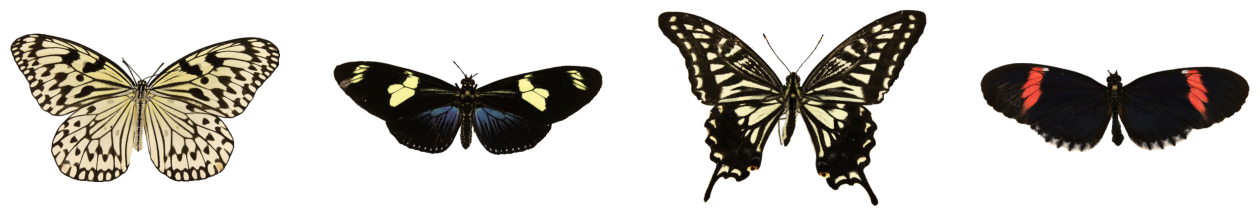

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

Все изображения в наборе данных разные, поэтому нам нужно сначала их предварительно обработать:
* `Resize` приводит изображения в соответствие с квадратным разрешением `config.image_size`.
* `RandomHorizontalFlip` дополняет набор данных, случайным образом зеркалируя изображения.
* `Normalize` важен для изменения масштаба значений пикселей в диапазон `[-1, 1]` (чего и ожидает наша модель).

In [ ]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

🤗 Наборы данных предлагают удобный метод set_transform() для применения преобразований изображений «на лету» во время обучения:

In [ ]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

Давайте посмотрим, как они выглядят сейчас

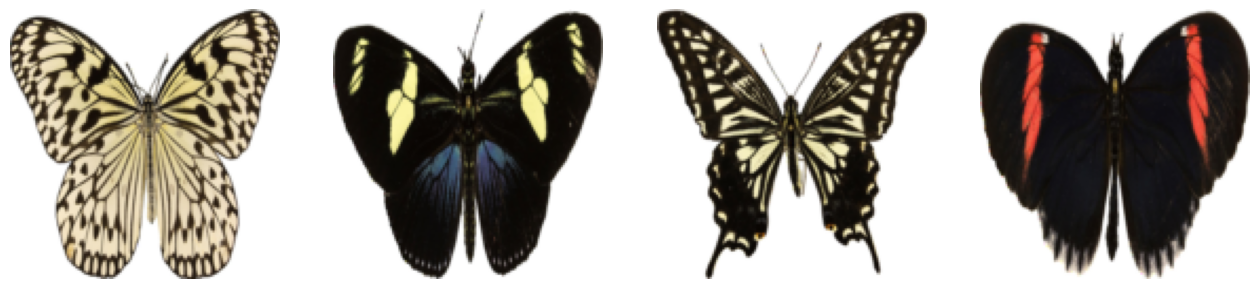

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["images"]):
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

Теперь, когда все наши изображения имеют одинаковый размер и преобразованы в тензоры, мы можем создать dataloader, который будем использовать для обучения.

In [ ]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

Большинство моделей диффузии используют архитектуру, которая представляет собой вариант [U-net](https://arxiv.org/abs/1505.04597), и именно ее мы здесь и будем использовать.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

В двух словах:
- в модели входное изображение проходит через несколько блоков слоев ResNet, что уменьшает размер изображения вдвое на 2.
- затем через то же количество блоков, которые снова повышают дискретизацию.
- существуют пропущенные соединения, связывающие объекты на пути понижения разрешения с соответствующими слоями на пути повышения разрешения.

Ключевой особенностью этой модели является то, что она предсказывает изображения того же размера, что и входные данные, а это именно то, что нам здесь нужно.

Diffusers предоставляет нам удобный класс `UNet2DModel`, который создает желаемую архитектуру в PyTorch.

Давайте создадим U-сеть для желаемого размера изображения.
Обратите внимание, что `down_block_types` соответствуют блокам понижающей дискретизации (зеленые на диаграмме выше), а `up_block_types` — это блоки повышающей дискретизации (красные на диаграмме):

In [ ]:
from diffusers import UNet2DModel


model = UNet2DModel(
    sample_size=config.image_size,  # разрешение таргетного изображения
    in_channels=3,  # количество входных каналов, 3 для RGB изображений
    out_channels=3,  # количество выходных каналов
    layers_per_block=2,  # сколько ResNet слоев использовать для каждого UNet блока
    block_out_channels=(128, 128, 256, 256, 512, 512),  # количество выходных каналов для каждого UNet блока
    down_block_types=(
        "DownBlock2D",  # обычный ResNet блок понижения дискретизации
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # ResNet блок понижения дискретизации с самовниманием
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # обычный ResNet блок повышения дискретизации
        "AttnUpBlock2D",  # a ResNet блок повышения дискретизации с самовниманием
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
      ),
)

Давайте получим образец изображения из нашего набора данных и передадим его в нашу модель. Нам просто нужно добавить измерение партии:

In [ ]:
sample_image = dataset[0]['images'].unsqueeze(0)
print('Input shape:', sample_image.shape)

Input shape: torch.Size([1, 3, 128, 128])


И давайте проверим, что на выходе получается тензор той же самой формы:

In [ ]:
print('Output shape:', model(sample_image, timestep=0).sample.shape)

Output shape: torch.Size([1, 3, 128, 128])


Отлично!

Обратите внимание, что наша модель учитывает (зашумленное) изображение, а также текущий временной шаг (как мы видели ранее в обзоре обучения). Эта информация о временном шаге преобразуется для модели с использованием синусоидального позиционного внедрения, аналогично тому, что часто делают модели Transformer.

Теперь, когда у нас есть модель, нам просто нужен объект, чтобы *добавлять шум к изображению*. Это делается **планировщиками** библиотеки `diffusers`.

## Определение scheduler

В зависимости от алгоритма диффузии, который вы хотите использовать, способ зашумления изображений немного отличается. Вот почему 🤗 Diffusers содержит различные классы планировщика, каждый из которых определяет этапы диффузии, специфичные для алгоритма. Здесь мы собираемся использовать `DDPMScheduler`, который соответствует алгоритму шумоподавления и обучения, предложенному в [Вероятностные модели диффузии шумоподавления] (https://arxiv.org/abs/2006.11239).

In [ ]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

Давайте посмотрим, как работает этот планировщик шума: он берет батч изображений из обучающего набора (здесь мы будем повторно использовать пакет одного изображения в форме `sample_image`), батч случайного шума той же формы и временные шаги для каждого изображения. (что соответствует количеству раз, которое мы хотим применить к каждому изображению):

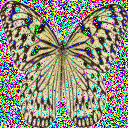

In [ ]:
import torch
from PIL import Image

noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

В алгоритме DDPM цель обучения модели состоит в том, чтобы иметь возможность предсказать шум, который мы использовали в `noise_scheduler.add_noise`, поэтому потери на этом этапе будут следующими:

In [ ]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

## Настройка обучения

У нас есть все необходимое для обучения нашей модели! Воспользуемся стандартным оптимизатором AdamW:

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

И косинусный scheduler:

In [ ]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

Чтобы оценить нашу модель, мы используем DDPMPipeline, который представляет собой простой способ выполнения сквозного вывода. Мы будем использовать этот конвейер для создания пакета образцов изображений и сохранения его в виде сетки на диск.

In [ ]:
from diffusers import DDPMPipeline

import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Сэмплируем несколько изображений из случайного шума (это обратный процесс диффузии).
    # Выход пайплайна по умолчанию - `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Делаем сетку из изображений
    image_grid = make_grid(images, rows=4, cols=4)

    # Сохраняем изображения
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

В итоге мы можем сгруппировать все вместе и написать нашу обучающую функцию. Это просто завершает этап обучения, который мы видели в предыдущем разделе.

In [ ]:
model = model.to(torch_device)

In [ ]:
from huggingface_hub import HfFolder, Repository, whoami

from tqdm.auto import tqdm
from pathlib import Path
import os

def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    global_step = 0

    # Теперь обучаем модель
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader))
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images'].to(torch_device)
            # Сэмплируем шум чтобы добавить к изображениям
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Сэмплируем временной шаг для каждого изображений
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Добавляем шум к чистым изображениям в соответствии с величиной шума на каждом временном шаге
            # (это процесс прямой диффузии)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            # Предсказываем остаток шума
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            loss.backward()

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            global_step += 1

        # После каждой эпохи вы при желании можете сэмплировать несколько изображений с помощью функции evaluate() и сохранить модель.
        pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)

        if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
            evaluate(config, epoch, pipeline)

        if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
            pipeline.save_pretrained(config.output_dir)

## Давайте обучать!

Давайте запустим обучение. Перед запуском перезагрузите среду, так как у вас не хватит памяти на GPU


In [ ]:
#exit(0)

In [ ]:
train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

  0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 59.06 MiB is free. Process 270818 has 14.69 GiB memory in use. Of the allocated memory 13.81 GiB is allocated by PyTorch, and 726.97 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)

evaluate(config, 0, pipeline)

Давайте посмотрим на окончательную сетку изображения, созданную обученной моделью диффузии:

In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

5 эпох получилось маловато, но образы бабочек есть. Если захотите получить хорошие изображения, то поставить 30 эпох. А вообще, всегда есть куда совершенствоваться, поэтому не стесняйтесь экспериментировать с гиперпараметрами, определением модели и увеличением изображений 🤗

Если вы решили загрузить модель в Hugging Face Hub, ее репозиторий теперь должен выглядеть так:
https://huggingface.co/anton-l/ddpm-butterflies-128/tree/main

Если вы хотите глубже погрузиться в код, у нас также есть более сложные сценарии обучения с такими функциями, как экспоненциальное скользящее среднее весов модели:

https://github.com/huggingface/diffusers/tree/main/examples


## **Итоги занятия**

Мы подробно познакомились с библиотекой diffusers, где реализованы основные диффузионных модели и научились использовать уже готовые модели и обучать свои собственные.
